In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gmr import GMM

from scipy.io.arff import loadarff
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from scipy.special import kl_div

from moebius.model.gmm.bn import ContinuousBNSerializer, JsonDictSerializer, FilesystemStorage
from moebius.util import make_diagonal, print_gmm_params_fancy

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def explode_cluster(data, target, clusters):
    indices_0_1 = [idx for idx, x in enumerate(target) if x in clusters]
    
    return (
        [list(data[idx]) for idx in indices_0_1],
        [target[idx].decode('UTF-8') if isinstance(target[idx], np.bytes_) else target[idx] for idx in indices_0_1]
    )

In [6]:
data = loadarff('./datasets/openml/volcanoes-a1.arff')

rows = data[0]
meta = data[1]

X = rows[['V1', 'V2', 'V3']]
y = [int(each.decode('UTF-8')) for each in rows['Class']]

iris_pair_1_2 = explode_cluster(X, y, (4, 5))

In [7]:
j = FilesystemStorage().read('./bns_volcanoes/0.2_0.json')
d = JsonDictSerializer().deserialize(j)
net = ContinuousBNSerializer().deserialize(d)

In [63]:
data = net.sample(200)

gmm = GMM(n_components=2)
gmm.from_samples(data.to_numpy())

w = gmm.priors.tolist()
means = gmm.means.tolist()
cov = make_diagonal(gmm.covariances.tolist())

print_gmm_params_fancy(w, means, cov, decimal_places=3)

100%|██████████| 200/200 [00:00<00:00, 1262.49it/s]

 ---  weights   --- 
[0.058 0.942]
 ---   means    --- 
[[468.254 706.217 -11.6  ]
 [530.148 839.619   1.593]]
 --- covariance --- 
[[[ 2.560260e+02 -3.641600e+01 -2.843300e+01]
  [-3.641600e+01  3.537448e+04 -1.985818e+03]
  [-2.843300e+01 -1.985818e+03  7.517480e+02]]

 [[ 1.767850e+02 -4.999000e+00 -1.226000e+00]
  [-4.999000e+00  5.658990e+02 -1.185400e+01]
  [-1.226000e+00 -1.185400e+01  4.497810e+02]]]
 ---    OLR     --- 
0.2309397511019187


In [20]:
gmm = GaussianMixture(n_components = 2) 
gmm.fit(data)

sample = gmm.sample(100)
data = sample[0]
labels = sample[1]

olr_0_7 = [data, labels]

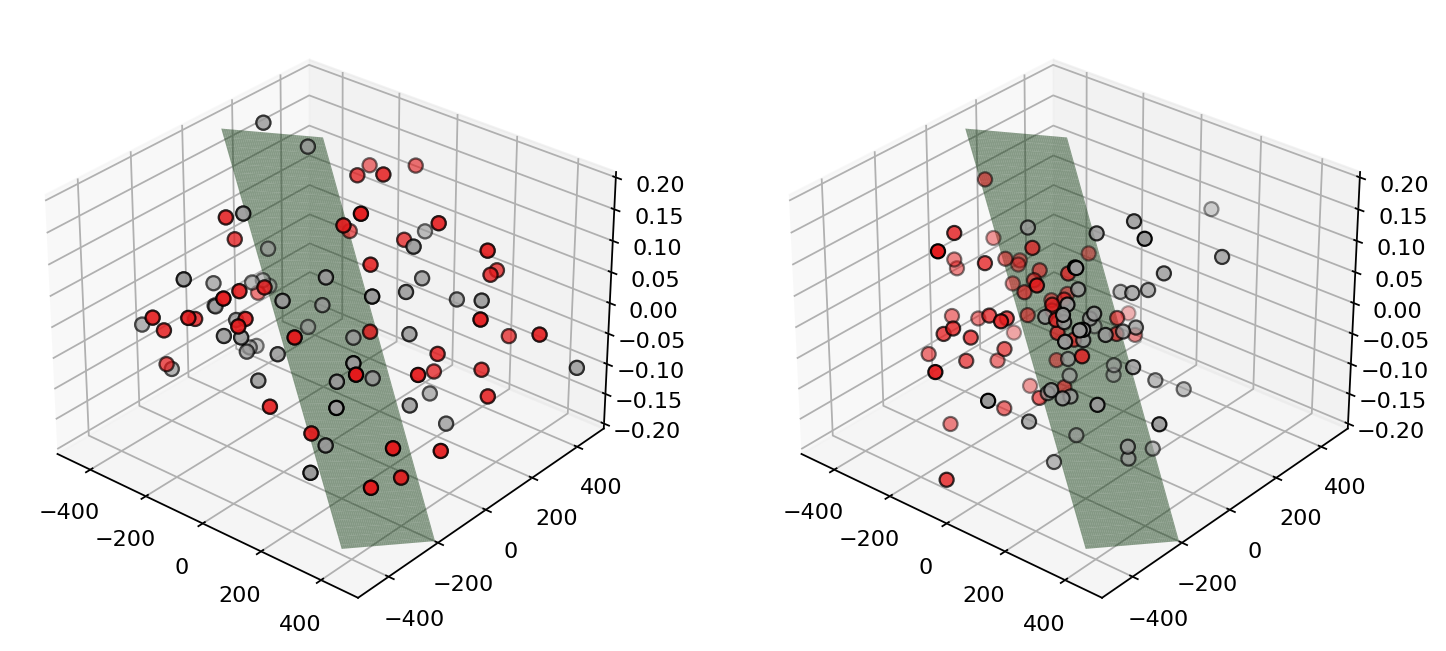

In [57]:
plt.rcParams['figure.dpi'] = 160

fig = plt.figure(figsize=(11, 11))
a,b = np.meshgrid(np.linspace(-200, 200, 100), np.linspace(-200, 200, 100))
z = None

i = 0
for X, y in [iris_pair_1_2, olr_0_7]:
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')

    X_reduced = PCA(n_components=3).fit_transform(X)

    if i == 0:
        model = SVC(kernel='linear')
        clf = model.fit(X_reduced, y)
        z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]
    
    ax.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        X_reduced[:, 2],
        c=y,
        cmap=plt.cm.get_cmap('Set1'),
        edgecolor="k",
        s=40,
    )
    
    ax.plot_surface(a, b, z(a,b), color='#1c4f1c', alpha=0.5)

        
    ax.set_xlabel("")
    ax.set_xlim([-500, 500])

    ax.set_ylabel("")
    ax.set_ylim([-500, 500])

    ax.set_zlabel("")
    ax.set_zlim([-0.20, 0.20])
    ax.view_init(30, -50)
    
    i += 1

plt.show()